In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# All Includes

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf 
from sklearn import metrics

In [ ]:
tf.__version__

'2.4.1'

In [ ]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

In [ ]:
DATASET_PATH = '/content/gdrive/MyDrive/Human Activity Recognition Using LSTM/UCI HAR Dataset/'

print("Dataset is now located at: " + DATASET_PATH)

Dataset is now located at: /content/gdrive/MyDrive/Human Activity Recognition Using LSTM/UCI HAR Dataset/


In [ ]:
TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

In [ ]:
print(X_train[0].shape)
print(y_train[0].shape)

(128, 9)
(1,)


In [ ]:
# Input Data

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


In [ ]:
X_train.shape

(7352, 128, 9)

In [ ]:
# Results
def plot_graph(pred):
  predictions = pred

  # print("Testing Accuracy: {}%".format(100*accuracy))

  print("")
  print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
  print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
  print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

  print("")
  print("Confusion Matrix:")
  confusion_matrix = metrics.confusion_matrix(y_test, predictions)
  print(confusion_matrix)
  normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

  print("")
  print("Confusion matrix (normalised to % of total test data):")
  print(normalised_confusion_matrix)
  print("Note: training and testing data is not equally distributed amongst classes, ")
  print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

  # Plot Results: 
  width = 12
  height = 12
  plt.figure(figsize=(width, height))
  plt.imshow(
      normalised_confusion_matrix, 
      interpolation='nearest', 
      cmap=plt.cm.rainbow
  )
  plt.title("Confusion matrix \n(normalised to % of total test data)")
  plt.colorbar()
  tick_marks = np.arange(6)
  plt.xticks(tick_marks, LABELS, rotation=90)
  plt.yticks(tick_marks, LABELS)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [ ]:
from tensorflow import keras
from keras.utils import plot_model

# callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, mode='min')
def LSTM_model():
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape = (128,9)))
  model.add(keras.layers.LSTM(units=256, return_sequences=True))
  model.add(keras.layers.LSTM(units=128, return_sequences=True))
  model.add(keras.layers.LSTM(units=64))
  model.add(keras.layers.Dense(128))
  model.add(keras.layers.Dense(6, activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
  return model

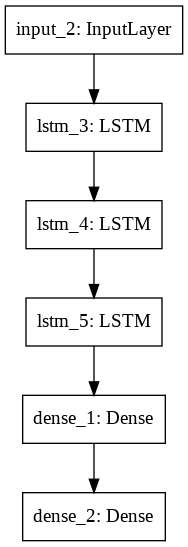

In [ ]:
lstm_model = LSTM_model()
plot_model(lstm_model)

In [ ]:
history = lstm_model.fit(X_train, y_train, epochs = 50, verbose=1, validation_split=0.3)

Epoch 1/50
161/161 [==============================] - 51s 108ms/step - loss: 1.3512 - accuracy: 0.3967 - val_loss: 0.7749 - val_accuracy: 0.6704
Epoch 2/50
161/161 [==============================] - 16s 100ms/step - loss: 0.7646 - accuracy: 0.6287 - val_loss: 0.8859 - val_accuracy: 0.6636
Epoch 3/50
161/161 [==============================] - 16s 99ms/step - loss: 0.5449 - accuracy: 0.7799 - val_loss: 1.3554 - val_accuracy: 0.4325
Epoch 4/50
161/161 [==============================] - 15s 94ms/step - loss: 1.4355 - accuracy: 0.3757 - val_loss: 0.4802 - val_accuracy: 0.8368
Epoch 5/50
161/161 [==============================] - 15s 92ms/step - loss: 0.2737 - accuracy: 0.9050 - val_loss: 0.3473 - val_accuracy: 0.9157
Epoch 6/50
161/161 [==============================] - 15s 92ms/step - loss: 0.1791 - accuracy: 0.9312 - val_loss: 1.1130 - val_accuracy: 0.7131
Epoch 7/50
161/161 [==============================] - 15s 92ms/step - loss: 0.1662 - accuracy: 0.9342 - val_loss: 0.4008 - val_accurac


Precision: 91.63169918809794%
Recall: 91.55072955548015%
f1_score: 91.57862530196597%

Confusion Matrix:
[[464  22   9   0   1   0]
 [ 16 452   3   0   0   0]
 [  0   0 420   0   0   0]
 [  0   0   0 400  85   6]
 [  0   0   0  91 441   0]
 [  0   0   0  16   0 521]]

Confusion matrix (normalised to % of total test data):
[[15.744824    0.7465219   0.3053953   0.          0.03393281  0.        ]
 [ 0.542925   15.337631    0.10179844  0.          0.          0.        ]
 [ 0.          0.         14.251782    0.          0.          0.        ]
 [ 0.          0.          0.         13.573125    2.884289    0.20359688]
 [ 0.          0.          0.          3.087886   14.964371    0.        ]
 [ 0.          0.          0.          0.542925    0.         17.678995  ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier in the last category.


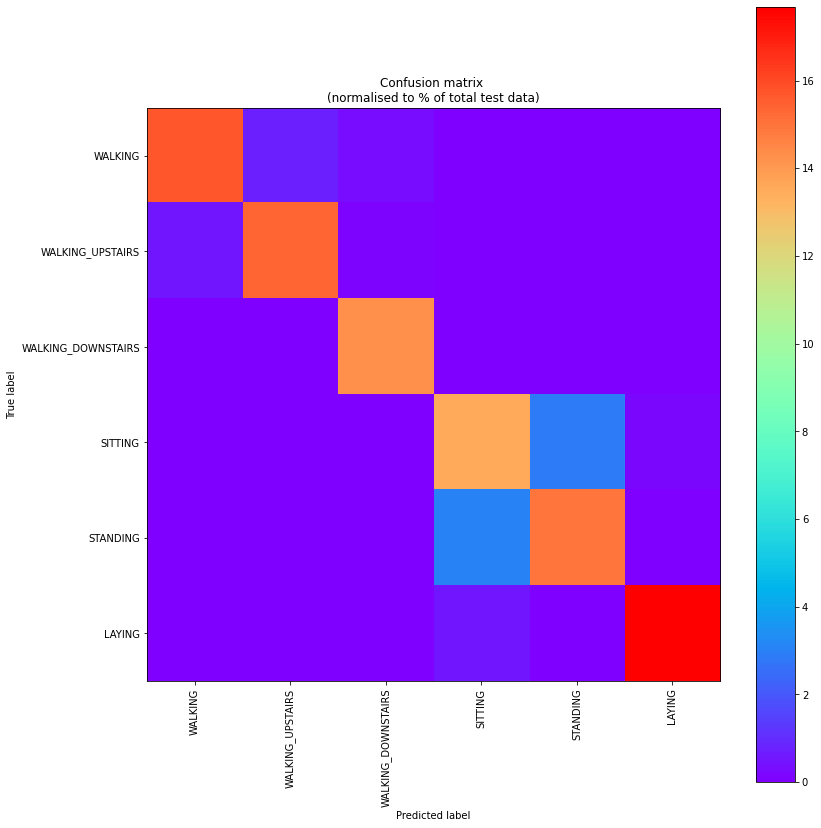

In [ ]:
pred = [np.argmax(eval) for eval in lstm_model.predict(X_test)]
test_data = [i[0] for i in y_test]
plot_graph(pred)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(pred,test_data))

0.9155072955548015


In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='sparse_categorical_crossentropy (training data)')
  plt.plot(history.history['val_loss'], label='sparse_categorical_crossentropy (validation data)')
  plt.title('sparse_categorical_loss for Human Activity Recognition tasks')
  plt.ylabel('sparse_categorical_crossentropy value')
  plt.xlabel('No. epoch')
  plt.legend(loc="upper left")
  plt.show()

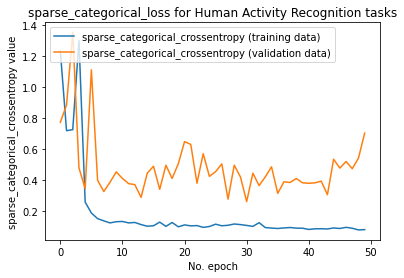

In [ ]:
plot_loss(history)

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, LSTM, Reshape, Bidirectional


def build_model():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(5, 1), input_shape=(128,9,1)))
    model.add(Activation("relu"))
    model.add(Conv2D(64, kernel_size=(5, 1)))
    model.add(Activation("relu"))
    model.add(Conv2D(64, kernel_size=(5, 1)))
    model.add(Activation("relu"))
    model.add(Conv2D(64, kernel_size=(5, 1)))
    model.add(Activation("relu"))
    model.add(Reshape((112, 9 * 64)))
    model.add(Bidirectional(LSTM(128, activation="tanh", return_sequences=True)))
    model.add(Bidirectional(LSTM(128, activation="tanh")))
    model.add(keras.layers.Dense(128))
    model.add(Dense(6, activation="softmax"))
    model.compile(
        loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(lr=0.001), metrics=["accuracy"]
    )
    return model

har = build_model()
har.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 9, 64)        384       
_________________________________________________________________
activation (Activation)      (None, 124, 9, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 9, 64)        20544     
_________________________________________________________________
activation_1 (Activation)    (None, 120, 9, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 116, 9, 64)        20544     
_________________________________________________________________
activation_2 (Activation)    (None, 116, 9, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 9, 64)       

In [ ]:
har_res = har.fit(np.expand_dims(X_train, axis=-1), y_train, epochs = 20, verbose=1, validation_split=0.3)

Epoch 1/20
161/161 [==============================] - 29s 138ms/step - loss: 0.7303 - accuracy: 0.6702 - val_loss: 0.3814 - val_accuracy: 0.8758
Epoch 2/20
161/161 [==============================] - 20s 125ms/step - loss: 0.1602 - accuracy: 0.9376 - val_loss: 0.3992 - val_accuracy: 0.8898
Epoch 3/20
161/161 [==============================] - 20s 125ms/step - loss: 0.1279 - accuracy: 0.9443 - val_loss: 0.3377 - val_accuracy: 0.8939
Epoch 4/20
161/161 [==============================] - 20s 124ms/step - loss: 0.1210 - accuracy: 0.9453 - val_loss: 0.3011 - val_accuracy: 0.9184
Epoch 5/20
161/161 [==============================] - 20s 125ms/step - loss: 0.1057 - accuracy: 0.9509 - val_loss: 0.2799 - val_accuracy: 0.9270
Epoch 6/20
161/161 [==============================] - 20s 125ms/step - loss: 0.0728 - accuracy: 0.9613 - val_loss: 0.3085 - val_accuracy: 0.9288
Epoch 7/20
161/161 [==============================] - 20s 126ms/step - loss: 0.0696 - accuracy: 0.9682 - val_loss: 0.3246 - val_ac

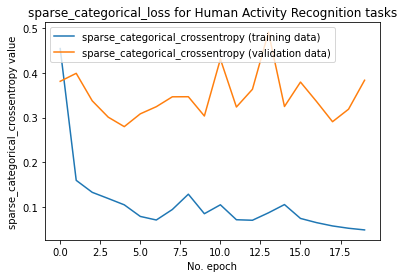

In [ ]:
plot_loss(har_res)


Precision: 91.41851351456168%
Recall: 91.00780454699695%
f1_score: 91.08235305607829%

Confusion Matrix:
[[453   3  40   0   0   0]
 [  4 431  36   0   0   0]
 [  3   0 417   0   0   0]
 [  0   2   0 414  74   1]
 [  1   2   0  81 448   0]
 [  0   0   0   0  18 519]]

Confusion matrix (normalised to % of total test data):
[[15.371564    0.10179844  1.3573124   0.          0.          0.        ]
 [ 0.13573125 14.625043    1.2215812   0.          0.          0.        ]
 [ 0.10179844  0.         14.149983    0.          0.          0.        ]
 [ 0.          0.06786563  0.         14.048184    2.5110283   0.03393281]
 [ 0.03393281  0.06786563  0.          2.748558   15.2019005   0.        ]
 [ 0.          0.          0.          0.          0.6107906  17.61113   ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier in the last category.


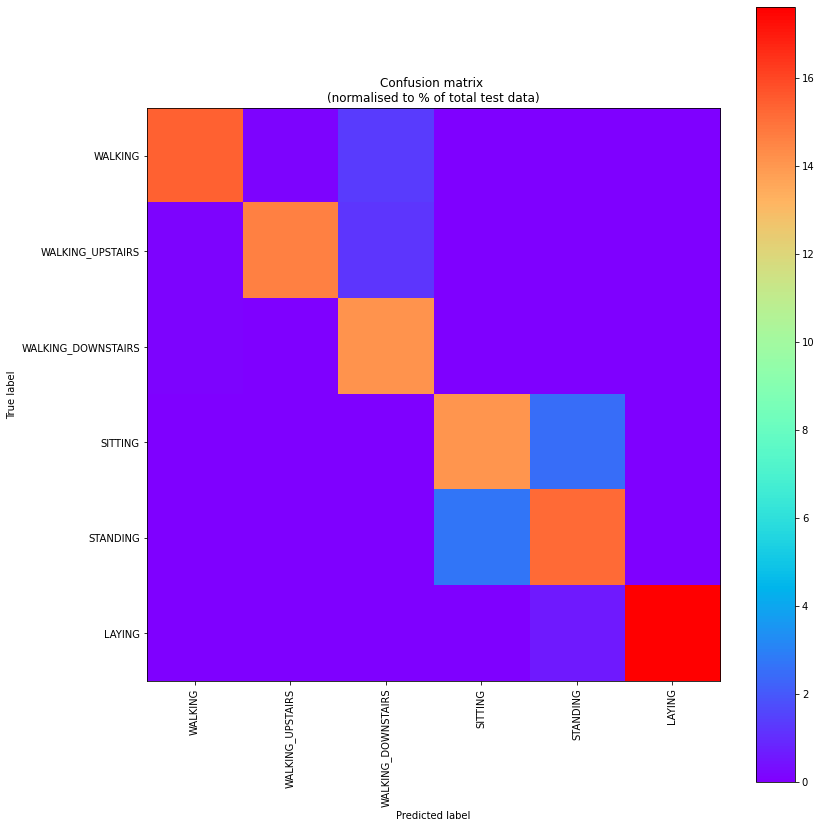

In [ ]:
pred1 = [np.argmax(eval) for eval in har.predict(np.expand_dims(X_test,axis = -1))]
test_data = [i[0] for i in y_test]
plot_graph(pred1)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(pred1,test_data))

0.9100780454699695
